In [1]:
# Import relevant packages

# for data
import pandas as pd
import numpy as np
from pandas_datareader import data

# for models
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# for plotting
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Init. models 

# scale pca ols
scale_pca_ols = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=4)),
        ('ols', LinearRegression())])

# ols
ols = LinearRegression()

In [3]:
# Download data

# inputs
tickers = ['^GSPC', 'IEF', 'DX-Y.NYB', 'GC=F']
start_date = '2006-11-15'
end_date = '2021-01-15'

# download data from yahoo finance
panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)

# take adjusted close and compute log-returns
my_data = panel_data["Adj Close"].apply(np.log).diff()
# change names
my_data.rename(columns={"^GSPC": "SP500", "IEF": "7_10_years", "DX-Y.NYB": "DXY", "GC=F": "Gold"}, inplace=True)
column_names = my_data.columns

In [4]:
# Build lhs and rhs 

# predictors: lagged 1 day and 1, 3, 6 and 12 months (~21 trading days in a month)
pred_lags = [1, 21, 3*21, 6*21, 12*21]
for x in column_names:
    for j in pred_lags:
        my_data[x+"_lag"+str(j)] = my_data[x].shift(j)
my_data.dropna(inplace=True)
y_data = my_data[column_names]
x_data = my_data.drop(column_names, axis=1)

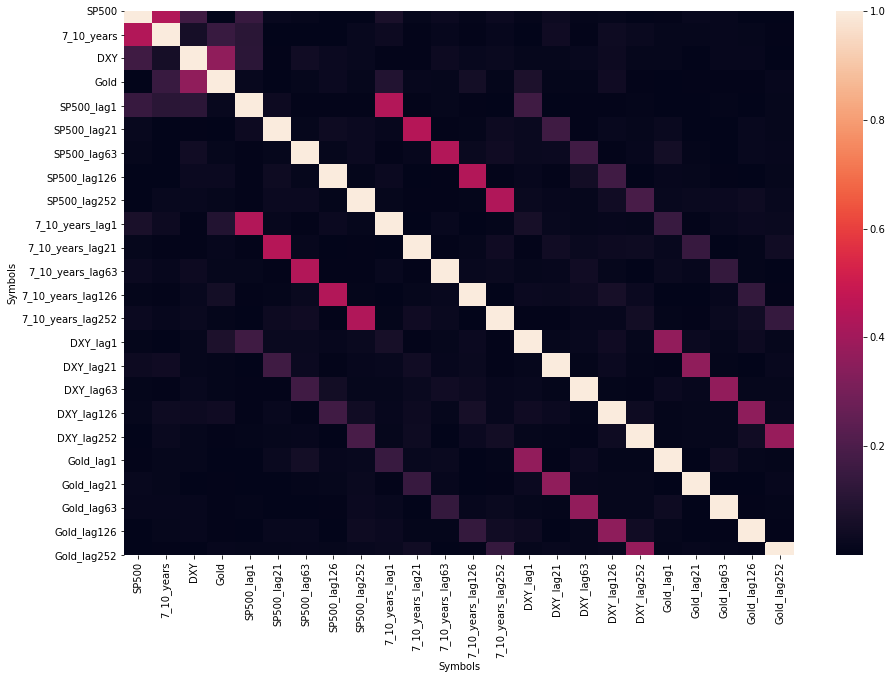

In [5]:
## Heatmap correlation
# calculate the correlation matrix
corr = my_data.corr().apply(np.abs)
# plot the heatmap
fig, ax = plt.subplots(figsize=(15,10)) 
g = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, ax = ax)

In [6]:
# Define rolling window size and re-calibration period

# rolling window size (~2y)
rol_wind_size = 500

# re-estimation period (~3 months)
re_calibration = 3*21

# get time index
time_index = my_data.index

# get re-estimation indeces
re_est_indeces = np.arange(rol_wind_size, len(time_index), re_calibration)
# and add last index if not included
if re_est_indeces[-1]<len(time_index):
    re_est_indeces = np.append(re_est_indeces, len(time_index))

In [7]:
# Out of sample predictions

# store true values and initialize array collecting predictions
true = y_data[rol_wind_size:]
pred_ols = true.copy()*0
pred_pca_ols = true.copy()*0

# loop over targets and time
for i, t in enumerate(re_est_indeces[:-1]):
    y_train, x_train, x_for_pred = y_data[t-rol_wind_size:t], x_data[t-rol_wind_size:t], x_data[t:re_est_indeces[i+1]]
    for col in column_names:
        ols.fit(x_train, y_train[col])
        pred_ols[col][t-rol_wind_size:re_est_indeces[i+1]-rol_wind_size] = ols.predict(x_for_pred)
        scale_pca_ols.fit(x_train, y_train[col])
        pred_pca_ols[col][t-rol_wind_size:re_est_indeces[i+1]-rol_wind_size] = scale_pca_ols.predict(x_for_pred)

In [8]:
# Simple forecasting comparison between OLS and PCA+OLS

# in terms of squared errors
se_ols = (true - pred_ols)**2
se_pca_ols = (true - pred_pca_ols)**2
print("% of times squared errors ols are higher than squared error pca+ols: ")
print(100*np.sum(se_ols>se_pca_ols)/len(se_ols))
print() 

# in terms of sign matching
sign_match_ols = true.apply(np.sign)*pred_ols.apply(np.sign)
sign_match_pca_ols = true.apply(np.sign)*pred_pca_ols.apply(np.sign)
print("% of times ols matches sign: ")
print(100*np.sum(sign_match_ols>0)/len(sign_match_ols))
print() 
print("% of times pca+ols matches sign: ")
print(100*np.sum(sign_match_pca_ols>0)/len(sign_match_pca_ols))

% of times squared errors ols are higher than squared error pca+ols: 
Symbols
SP500         54.458217
7_10_years    53.138745
DXY           52.858856
Gold          54.338265
dtype: float64

% of times ols matches sign: 
Symbols
SP500         50.819672
7_10_years    50.659736
DXY           50.579768
Gold          51.099560
dtype: float64

% of times pca+ols matches sign: 
Symbols
SP500         51.659336
7_10_years    50.659736
DXY           50.819672
Gold          51.099560
dtype: float64


In [9]:
# Implementing long-short strategies

# Compute returns
r_ls_ols = true*pred_ols.apply(np.sign)
r_ls_pca_ols = true*pred_pca_ols.apply(np.sign)
r_alwys_long = true.copy()

# Cumulate them (they are log-returns, so just cum sum and then exp)
pnl_ls_ols = r_ls_ols.cumsum().apply(np.exp)
pnl_ls_pca_ols = r_ls_pca_ols.cumsum().apply(np.exp)
pnl_alwys_long = r_alwys_long.cumsum().apply(np.exp)

C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


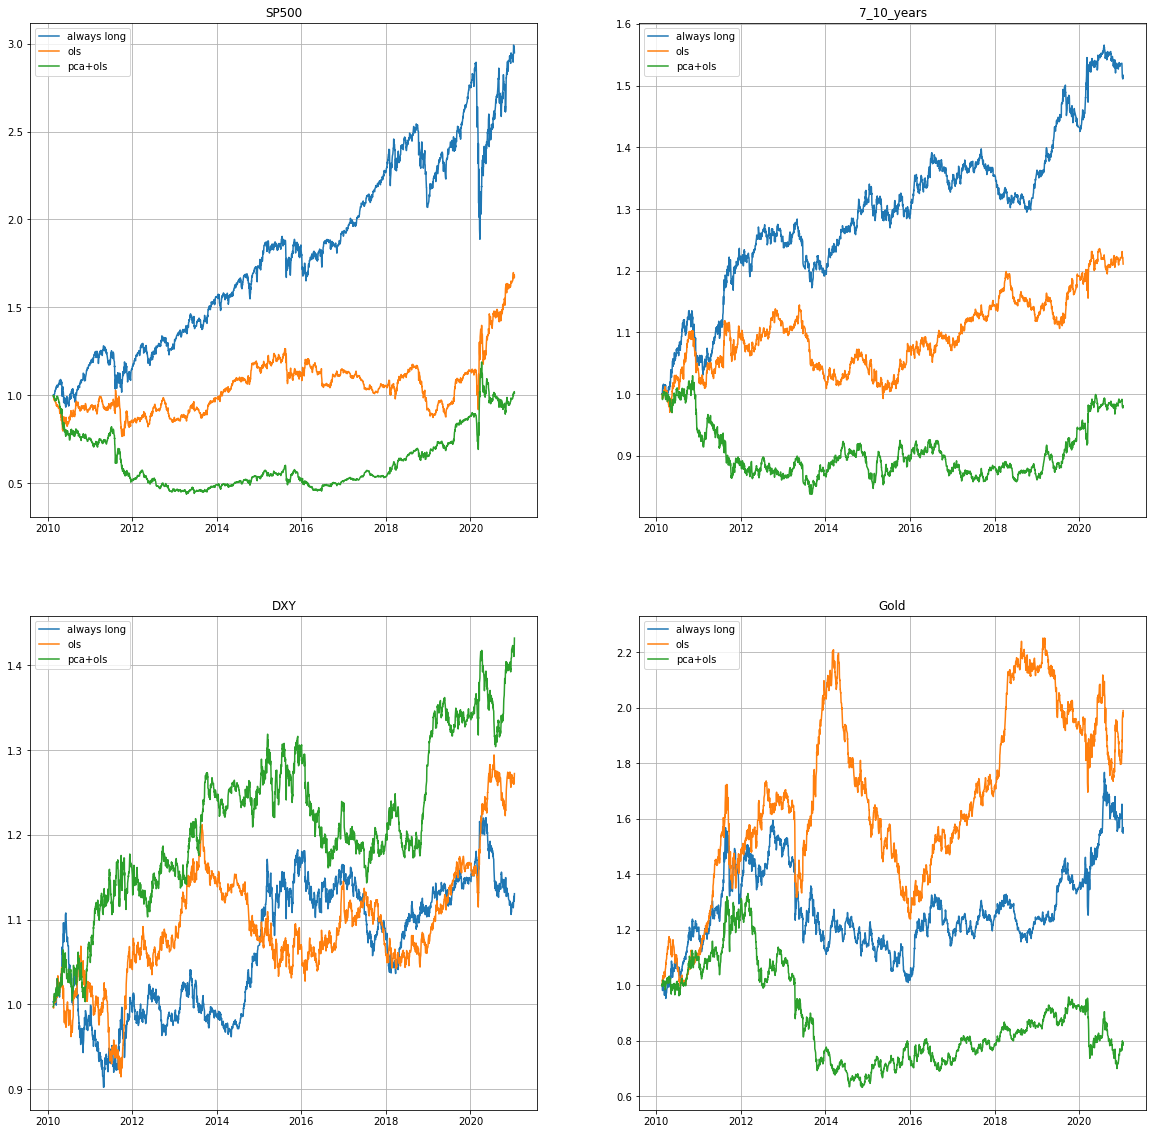

In [10]:
# Plotting them

fig = plt.figure(figsize=(20,20))

gs = fig.add_gridspec(2, 2)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])

ax11.plot(pnl_alwys_long[column_names[0]], label='always long')
ax11.plot(pnl_ls_ols[column_names[0]], label='ols')
ax11.plot(pnl_ls_pca_ols[column_names[0]], label='pca+ols')
ax11.set_title(column_names[0])
ax11.legend()
ax11.grid()

ax12.plot(pnl_alwys_long[column_names[1]], label='always long')
ax12.plot(pnl_ls_ols[column_names[1]], label='ols')
ax12.plot(pnl_ls_pca_ols[column_names[1]], label='pca+ols')
ax12.set_title(column_names[1])
ax12.legend()
ax12.grid()

ax21.plot(pnl_alwys_long[column_names[2]], label='always long')
ax21.plot(pnl_ls_ols[column_names[2]], label='ols')
ax21.plot(pnl_ls_pca_ols[column_names[2]], label='pca+ols')
ax21.set_title(column_names[2])
ax21.legend()
ax21.grid()

ax22.plot(pnl_alwys_long[column_names[3]], label='always long')
ax22.plot(pnl_ls_ols[column_names[3]], label='ols')
ax22.plot(pnl_ls_pca_ols[column_names[3]], label='pca+ols')
ax22.set_title(column_names[3])
ax22.legend()
ax22.grid()

In [11]:
# Sharpe ratio
for col in column_names:
    print('Sharpe ratio on asset ', col)
    print(' - always long is: ', np.round(np.mean(r_alwys_long[col])/ np.std(r_alwys_long[col]), 3))
    print(' - based on ols forecast is: ', np.round(np.mean(r_ls_ols[col])/ np.std(r_ls_ols[col]),3))
    print(' - based on pca+ols forecast is: ', np.round(np.mean(r_ls_pca_ols[col])/ np.std(r_ls_pca_ols[col]),3))

Sharpe ratio on asset  SP500
 - always long is:  0.039
 - based on ols forecast is:  0.019
 - based on pca+ols forecast is:  0.001
Sharpe ratio on asset  7_10_years
 - always long is:  0.044
 - based on ols forecast is:  0.02
 - based on pca+ols forecast is:  -0.002
Sharpe ratio on asset  DXY
 - always long is:  0.011
 - based on ols forecast is:  0.022
 - based on pca+ols forecast is:  0.032
Sharpe ratio on asset  Gold
 - always long is:  0.017
 - based on ols forecast is:  0.027
 - based on pca+ols forecast is:  -0.009
